### Данный проект является учебным, направлен на изучение языка python, анализа данных и не несет в себе инвестиционных рекомендаций.

In [332]:
from datetime import date, timedelta, datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import investpy
import pylab 
import scipy.stats as stats

In [333]:
# Указываем вводные данные

today = date.today().strftime("%d/%m/%Y")
# ==========================================================================================
stock = 'CLF' # указываем тикер акции
country = 'United States'
date_from = '01/01/2020'   # необходимо ввести дату, с которой собираем данные о котировках
date_to = today    # дата, по которую собираем данные, по умолчанию сегодняшний день
# =========================================================================================
# выбираем дату с которой строим графики, формат МЕСЯЦ/день/год
date_plot = '07/01/2021'

# выбираем дату для анализа и оценки эффективности стратегии (дату, с которой мы потенциально могли использовать стратегию)

strategy_date_from = date_plot # по умолчанию дата такая же, как для построения графиков

In [334]:
# Загружаем исторические данные, содержащие дневные ценовые диапазоны акций за указанный период
df = investpy.get_stock_historical_data(stock = stock,
                                        country = country,
                                        from_date = date_from,
                                        to_date = today)

In [335]:
# stocks_df = df.reset_index()
stocks_df = df

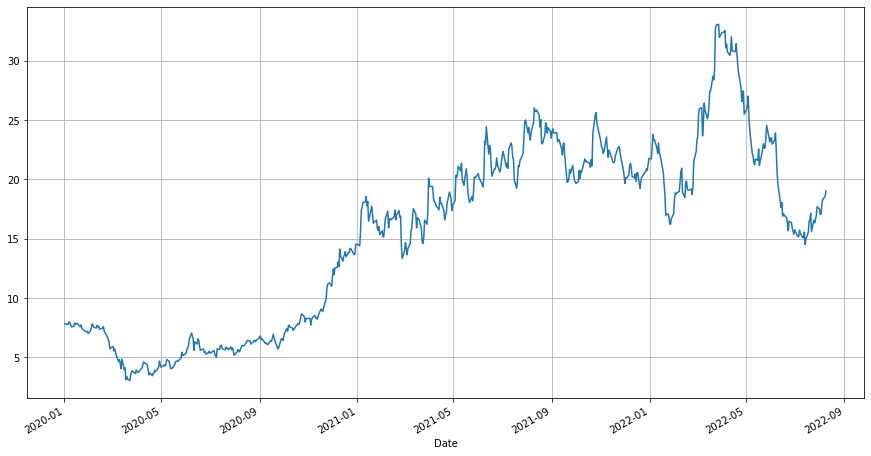

In [336]:
# Строим график изменения цены за весь период
stocks_df.Close.plot(figsize=(15,8))
plt.grid(True)

In [337]:
# Функции расчетов скользящих средних
# Simple Moving Average
def SMA(data, ndays): 
     SMA = pd.Series(data['Close'].rolling(ndays).mean().round(4), name = 'SMA' + str(ndays))  
     return SMA

# Exponentially-weighted Moving Average 
def EWMA(data, ndays): 
     EMA = pd.Series(data['Close'].ewm(span = ndays, min_periods = ndays - 1).mean().round(4), 
                 name = 'EWMA_' + str(ndays))
     return EMA

In [338]:
# Считаем динамику изменения цены акции по дням и изменение в процентном соотношении
stocks_df['range'] = stocks_df.High - stocks_df.Low
stocks_df['score'] = ((stocks_df.Close - stocks_df.Open)/stocks_df.Open).mul(100).round(2)

In [339]:
# Рассчитываем простые и экспоненциальные скользящие средние
# Calculate simple and exponential moving average
stocks_df['sma10'] = SMA(stocks_df, 10)
stocks_df['ema10'] = EWMA(stocks_df,10)
stocks_df['ema12'] = EWMA(stocks_df,12)
stocks_df['ema26'] = EWMA(stocks_df,26)

In [340]:
# В стратегии MACD мы используем две линии: линия MACD - Схождение/расхождение скользящих средних,
# которая представляет собой разницу между 26-дневной EMA и 12-дневной EMA, и сигнальную линию,
# которая является 9-дневной EMA линии MACD

# Calculate MACD
stocks_df['macd'] = stocks_df['ema12']- stocks_df['ema26'] 

# Calculate Signal
stocks_df['macdsignal'] = stocks_df.macd.ewm(span=9, adjust=False).mean()

In [341]:
# Создание торгового сигнала
# Define Signal, 1 значит сигнал к покупке, -1 сигнал к продаже
stocks_df['trading_signal_macd'] = np.where(stocks_df['macd'] > stocks_df['macdsignal'], 1, -1)

In [342]:
stocks_df

,Open,High,Low,Close,Volume,Currency,range,score,sma10,ema10,ema12,ema26,macd,macdsignal,trading_signal_macd
Date,,,,,,,,,,,,,,,
2020-01-02,8.44,8.46,7.78,7.84,19356932,USD,0.68,-7.11,NaN,NaN,NaN,NaN,NaN,NaN,-1
2020-01-03,7.85,8.02,7.75,7.82,8679442,USD,0.27,-0.38,NaN,NaN,NaN,NaN,NaN,NaN,-1
2020-01-06,7.78,7.91,7.64,7.79,9275715,USD,0.27,0.13,NaN,NaN,NaN,NaN,NaN,NaN,-1
2020-01-07,7.79,8.15,7.78,8.00,12107122,USD,0.37,2.70,NaN,NaN,NaN,NaN,NaN,NaN,-1
2020-01-08,7.98,8.10,7.89,7.93,9823344,USD,0.21,-0.63,NaN,NaN,NaN,NaN,NaN,NaN,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-03,17.09,17.25,16.90,17.12,9912086,USD,0.35,0.18,16.865,16.8650,16.7823,16.8676,-0.0853,-0.413776,1
2022-08-04,17.18,18.33,17.05,17.94,16531666,USD,1.28,4.42,16.945,17.0605,16.9604,16.9470,0.0134,-0.328341,1
2022-08-05,17.73,18.79,17.66,18.31,12354804,USD,1.13,3.27,17.214,17.2877,17.1681,17.0480,0.1201,-0.238652,1


In [343]:
stocks_df = stocks_df.dropna()

In [344]:
stocks_df

,Open,High,Low,Close,Volume,Currency,range,score,sma10,ema10,ema12,ema26,macd,macdsignal,trading_signal_macd
Date,,,,,,,,,,,,,,,
2020-02-06,7.90,7.93,7.67,7.71,6421009,USD,0.26,-2.41,7.351,7.4888,7.4868,7.5211,-0.0343,-0.034300,-1
2020-02-07,7.62,7.65,7.50,7.55,5705900,USD,0.15,-0.92,7.368,7.5000,7.4967,7.5236,-0.0269,-0.032820,1
2020-02-10,7.51,7.56,7.40,7.48,4860108,USD,0.16,-0.40,7.393,7.4963,7.4941,7.5199,-0.0258,-0.031416,1
2020-02-11,7.58,7.85,7.55,7.70,6455783,USD,0.30,1.58,7.447,7.5335,7.5261,7.5350,-0.0089,-0.026913,1
2020-02-12,7.85,7.89,7.57,7.58,9990566,USD,0.32,-3.44,7.486,7.5420,7.5344,7.5387,-0.0043,-0.022390,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-03,17.09,17.25,16.90,17.12,9912086,USD,0.35,0.18,16.865,16.8650,16.7823,16.8676,-0.0853,-0.413776,1
2022-08-04,17.18,18.33,17.05,17.94,16531666,USD,1.28,4.42,16.945,17.0605,16.9604,16.9470,0.0134,-0.328341,1
2022-08-05,17.73,18.79,17.66,18.31,12354804,USD,1.13,3.27,17.214,17.2877,17.1681,17.0480,0.1201,-0.238652,1


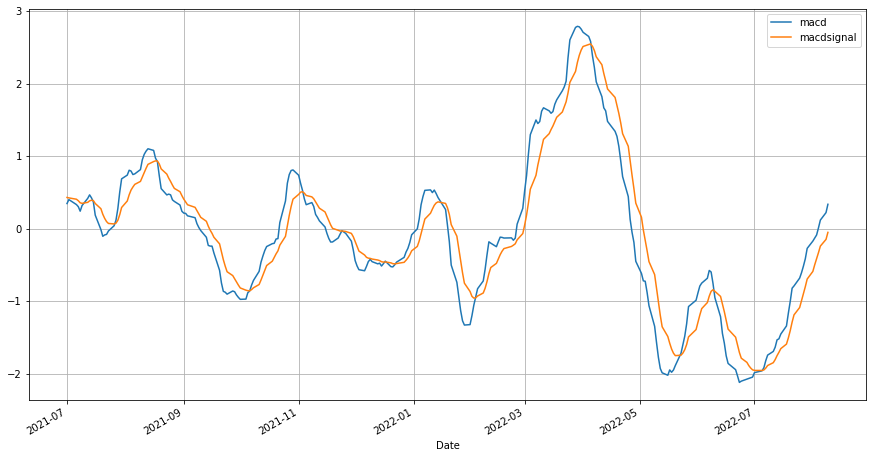

In [345]:
# строим график линии MACD, которая представляет собой разницу между 26-дневной EMA и 12-дневной EMA,
# и сигнальную линию, которая является 9-дневной EMA линии MACD
# Когда линия MACD пересекает сигнальную линию снизу вверх, рекомендуется покупать базовую ценную бумагу.
# Когда линия MACD пересекает сигнальную линию сверху вниз, срабатывает сигнал на продажу.
stocks_df[stocks_df.index >= date_plot][['macd','macdsignal']].plot(figsize=(15,8))
plt.grid(True)
plt.show()

In [346]:
# Убираем индексацию по дате
stocks_df = stocks_df.reset_index()

In [347]:
# создаем серию с данными о торговых сигналах для анализа частоты пересечений графиков скользящих средних
trading_signal_macd_intervals = stocks_df[stocks_df.Date >= date_plot] \
                            [['Date','trading_signal_macd']].set_index('Date')
trading_signal_macd_list = trading_signal_macd_intervals.trading_signal_macd.tolist()

In [348]:
# Считаем количество пересечений графиков скользящих средних, то есть интервалов

intervals = 1
k = 1

for i in trading_signal_macd_list:
    if k != len(trading_signal_macd_list):
        if i != trading_signal_macd_list[k]:
            intervals += 1
            k += 1
        else:
            k +=1
print('В заданном временном диапазоне с {} по {} графики MACD и MACD_signal пересекаются {} раз(а)' \
                        .format(datetime.strptime(date_plot, '%m/%d/%Y').strftime('%d/%m/%Y'), today, intervals-1))

В заданном временном диапазоне с 01/07/2021 по 10/08/2022 графики MACD и MACD_signal пересекаются 17 раз(а)


In [349]:
# Оптимизация кода. замена конструкции if (в старой версии) на цикл While. Находим сколько дней прошло с момента последнего торгового сигнала
# и выведем на экран сведения о цене акции по состоянию на дату последнего торгового сигнала
index = -1
while trading_signal_macd_list[index - 1] == trading_signal_macd_list[index]:
    index -= 1
    if  trading_signal_macd_list[index + 1] == 1:
        signal = 'Buy'
    else:
        signal = 'Sell'

last_signal_date = stocks_df.Date.iloc[len(stocks_df)-abs(index)].strftime('%d/%m/%Y')


print('The last trading signal was {} ({} trading sessions ago). Date {}'.format(signal, abs(index), last_signal_date))
print('------------------------------------------')
print(stocks_df.iloc[len(stocks_df)-abs(index)]) # выводим информацию по дате последнего актуального торгового сигнала

The last trading signal was Buy (25 trading sessions ago). Date 06/07/2022
------------------------------------------
Date                   2022-07-06 00:00:00
Open                                  15.0
High                                 15.43
Low                                  14.75
Close                                15.19
Volume                            22335308
Currency                               USD
range                                 0.68
score                                 1.27
sma10                               15.784
ema10                               16.009
ema12                              16.2789
ema26                              18.1948
macd                               -1.9159
macdsignal                       -1.945966
trading_signal_macd                      1
Name: 607, dtype: object


In [350]:
trading_signal_macd_intervals = trading_signal_macd_intervals.reset_index()

In [351]:
# находим уникальные даты сигналов и выносим в отдельный датафрейм, а также считаем длительность каждого
# тренда между сигналами к покупке/продаже и найдем среднюю продолжительность тренда согласно индикатору MACD

signal_dates_list = []
trade_signal_list = []

intervals_list = []

sum_i = 1
k = 1
for i in trading_signal_macd_intervals.trading_signal_macd:
    if k != len(trading_signal_macd_intervals.trading_signal_macd):
        if i == trading_signal_macd_intervals.trading_signal_macd[k]:
            sum_i += 1
            k += 1
        else:
            intervals_list.append(sum_i)
            sum_i = 1
            k += 1
            signal_dates_list.append(trading_signal_macd_intervals.Date[k-1])
            trade_signal_list.append(trading_signal_macd_intervals.trading_signal_macd[k-1])
    else:
        intervals_list.append(sum_i)
print(intervals_list)

trading_action_df = pd.DataFrame()
trading_action_df['Date'] = signal_dates_list
#trading_action_df['Signal'] = trade_signal_list

print('---------------------------------')
print('Средняя продолжительность локального тренда согласно индикатору MACD составляет {} дней'.format(pd.Series(intervals_list).mean()))


[6, 3, 8, 16, 35, 20, 14, 1, 15, 1, 3, 16, 12, 43, 32, 13, 16, 25]
---------------------------------
Средняя продолжительность локального тренда согласно индикатору MACD составляет 15.5 дней


In [352]:
# Оставляем в исходном датафрейме данные, содержащие информацию о днях, когда были сигналы к покупке/продаже
macd_analitics_df = trading_action_df.merge(stocks_df, on = 'Date')

In [353]:
# анализируем эффективности модели MACD, считаем доходность на одну акцию с учетом следования сратегии
# total_macd - сумма по колонке Close для всех торговых сигналов, если бы каждый раз мы продавали или покупали одну акцию
# чтобы посчитать эффективность модели, необходимо выбрать только закрытые сделки (количество покупок и продаж должно быть равным)

total_macd = macd_analitics_df[macd_analitics_df.trading_signal_macd == -1].Close.sum()- macd_analitics_df[macd_analitics_df.trading_signal_macd == 1].Close.sum()

if macd_analitics_df.trading_signal_macd.sum() > 0:
    total_macd = round(total_macd + macd_analitics_df.Close.tolist()[-1], 2)
    
elif macd_analitics_df.trading_signal_macd.sum() < 0:
    total_macd = round(total_macd - macd_analitics_df.Close.tolist()[0], 2)

print('Прибыль/убыток на каждую акцию {} от совершения всех предложенных сделок согласно индикатору MACD'.format(stock))
print('в период с {} по {} составил {}'.format(datetime.strptime(date_plot, '%m/%d/%Y').strftime('%d/%m/%Y'), today, total_macd))

print(trading_action_df.merge(stocks_df[['Date', 'trading_signal_macd', 'Close']], on = 'Date'))
print('-------------------------------')
print('total profit/loss per stock = {} {}'.format(total_macd, stocks_df.Currency[0]))

Прибыль/убыток на каждую акцию CLF от совершения всех предложенных сделок согласно индикатору MACD
в период с 01/07/2021 по 10/08/2022 составил 9.75
         Date  trading_signal_macd  Close
0  2021-07-12                    1  23.08
1  2021-07-15                   -1  21.62
2  2021-07-27                    1  22.26
3  2021-08-18                   -1  25.04
4  2021-10-07                    1  20.73
5  2021-11-04                   -1  22.18
6  2021-11-24                    1  22.77
7  2021-11-26                   -1  21.84
8  2021-12-17                    1  20.59
9  2021-12-20                   -1  19.23
10 2021-12-23                    1  20.29
11 2022-01-18                   -1  20.59
12 2022-02-03                    1  18.75
13 2022-04-06                   -1  31.09
14 2022-05-23                    1  23.01
15 2022-06-10                   -1  19.64
16 2022-07-06                    1  15.19
-------------------------------
total profit/loss per stock = 9.75 USD


In [355]:
# подготовим датайрейм для дальнейшего анализа (переименуем колонки для удобства)
trading_action_df = trading_action_df.merge(stocks_df[['Date', 'trading_signal_macd', 'Close']], on = 'Date').rename(columns={'trading_signal_macd':'signal','Close':'price'})

In [365]:
trading_action_df.head()

,Date,signal,price
0,2021-07-12,1,23.08
1,2021-07-15,-1,21.62
2,2021-07-27,1,22.26
3,2021-08-18,-1,25.04
4,2021-10-07,1,20.73


### Далее проанилизируем эффективность индикатора в разрезе отдельных сделок

In [357]:
# создадим серию с датами сигналов к покупке и продаже
# далее трансормируем датафрейм таким образом, чтобы в одной строке у нас были даты сигналов к покупке и продаже, а также цены

In [358]:
if trading_action_df.signal.iloc[0] == trading_action_df.signal.iloc[-1]:
    trading_action_df = trading_action_df.drop(trading_action_df.index[-1])

In [359]:
sell_date = trading_action_df[trading_action_df.signal == -1].rename(columns = {'Date': 'sell_date', 'price': 'sell_price'}).drop(['signal'], axis = 1)
buy_date = trading_action_df[trading_action_df.signal == 1].rename(columns = {'Date': 'buy_date', 'price': 'buy_price'}).drop(['signal'], axis = 1)

In [360]:
join_df = pd.concat([buy_date.reset_index(drop = True), sell_date.reset_index(drop = True)],axis=1)

In [361]:
# добавим колонки со значением финансового результата совершенных сделок
join_df['result'] = join_df['sell_price'] - join_df['buy_price']
join_df['percent'] = round((join_df['result'] / join_df['buy_price']).mul(100), 2)
join_df['profit'] = join_df['result'] > 0

In [362]:
join_df

,buy_date,buy_price,sell_date,sell_price,result,percent,profit
0,2021-07-12,23.08,2021-07-15,21.62,-1.46,-6.33,False
1,2021-07-27,22.26,2021-08-18,25.04,2.78,12.49,True
2,2021-10-07,20.73,2021-11-04,22.18,1.45,6.99,True
3,2021-11-24,22.77,2021-11-26,21.84,-0.93,-4.08,False
4,2021-12-17,20.59,2021-12-20,19.23,-1.36,-6.61,False
5,2021-12-23,20.29,2022-01-18,20.59,0.30,1.48,True
6,2022-02-03,18.75,2022-04-06,31.09,12.34,65.81,True
7,2022-05-23,23.01,2022-06-10,19.64,-3.37,-14.65,False


In [363]:
join_df.result.describe()

count     8.000000
mean      1.218750
std       4.877304
min      -3.370000
25%      -1.385000
50%      -0.315000
75%       1.782500
max      12.340000
Name: result, dtype: float64

In [364]:
# подведем итоги: посчитаем статистику прибыльных и убыточных сделок
# финансовый результат или прирост капитала, выраженный в %
finance_result = round(((total_macd + join_df.buy_price[0]) / join_df.buy_price[0]) *100 - 100 , 2)

print('Всего за выбранный период было совершено {} сделок, из которых:'.format(len(join_df)) )
print('Прибыльных: {}, что составляет {} %'.format(len(join_df[join_df.profit == True]), (len(join_df[join_df.profit == True]) / len(join_df)) * 100 ))
print('Убыточных: {}, что составляет {} %'.format(len(join_df) - len(join_df[join_df.profit == True]), (len(join_df[join_df.profit == True]) / len(join_df)) * 100 ))
print('-----------------------------------')
print('Максимальная прибыль одной сделки {} %'.format(join_df.percent.max()))
print('Максимальный убыток одной сделки {} %'.format(join_df.percent.min()))
print('-----------------------------------')
print('Общий финансовый результат в период с {} по {} составил:'.format(datetime.strptime(date_plot, '%m/%d/%Y').strftime('%d/%m/%Y'), today))
print('{} %'.format(finance_result))

Всего за выбранный период было совершено 8 сделок, из которых:
Прибыльных: 4, что составляет 50.0 %
Убыточных: 4, что составляет 50.0 %
-----------------------------------
Максимальная прибыль одной сделки 65.81 %
Максимальный убыток одной сделки -14.65 %
-----------------------------------
Общий финансовый результат в период с 01/07/2021 по 10/08/2022 составил:
42.24 %
